In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn import metrics,linear_model,svm,preprocessing,tree,ensemble,naive_bayes,neighbors
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import learning_curve,cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import ta
import random
import seaborn as sns

## Loading Data

In [2]:
#Loading BTC/USD Prices
BTC = pd.read_csv('crypto_dfs/BTC-USD.csv')
features = BTC
features.set_index('Date',inplace=True)

#Loading BTC technical Analysis 
btc = pd.read_csv('crypto_dfs/btc.csv')
btc.set_index('date',inplace=True)
btc_2010 = btc.loc['2010-07-16':'2019-07-23']

In [3]:
features = features.join(btc_2010,how='outer')

## Feature Functions

In [4]:
def ExpMovingAvg(data, window):
    weights = np.exp(np.linspace(-1.,0.,window))
    weights /= weights.sum()
    
    a = np.convolve(data,weights)[:len(data)]
    a[:window] = None
    return a

def EMA(window):
    weights = np.exp(np.linspace(-1.,0.,window))
    weights /= weights.sum()
    
    a = np.convolve(features['Adj Close'],weights)[:len(features['Adj Close'])]
    a[:window] = None
    features['EMA_'+str(window)] = a
    
def RSISMA(window):
    delta = features['Adj Close'].diff()
    
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = np.array(up.rolling(window=window).mean())
    roll_down = np.array(down.abs().rolling(window=window).mean())

    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    features['RSI_SMA'] = RSI
    
def RSIEMA(window):
    delta = features['Adj Close'].diff()
    
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = ExpMovingAvg(up,window)
    roll_down = ExpMovingAvg(down.abs(),window)

    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    features['RSI_EMA'] = RSI
    
def target(data):
    deltas = data.diff()
    target = [1 if delta >= 0 else 0 for delta in deltas]
    target[0] = 1
    return target

def MA(window):
    features['MA_'+str(window)] = features['Adj Close'].rolling(window=window).mean()
    
def MovingAvg(data, window):
    SMA = data.rolling(window=window).mean()
    return np.array(SMA)

def UB(window):
    UB = features['High']*(1 + 4 * (features['High']-features['Low']) / (features['High'] + features['Low']))
    MA = MovingAvg(UB,window)
    features['UB_'+str(window)] = MA
    
def DB(window):
    DB = features['Low']*(1 - 4 * (features['High']-features['Low']) / (features['High'] + features['Low']))
    MA = MovingAvg(DB,window)
    features['DB_'+str(window)] = MA
    
def PROC(window):
    features['PROC_'+str(window)] = (features['Adj Close'] - features['Adj Close'].shift(window))/features['Adj Close'].shift(window)
    
def MFI(window):
    features['MFI_'+str(window)] = ta.momentum.money_flow_index(features['High'], features['Low'], features['Close'], features['Volume'], n=window, fillna=False)
    
def STO_SIG(window):
    features['STO_SIG_'+str(window)] = ta.momentum.stoch_signal(features['High'], features['Low'], features['Adj Close'], n=14, d_n=window, fillna=False)
       
def UO(s,m,l,ws,wm,wl):
    features['UO_'+str(s)+'_'+str(m)+'_'+str(l)] = ta.momentum.uo(features['High'], features['Low'], features['Adj Close'], s=s, m=m, len=l, ws=ws, wm=wm, wl=wl, fillna=False)
    
def CMF(window):
    features['CMF_'+str(window)] = ta.volume.chaikin_money_flow(features['High'], features['Low'], features['Adj Close'], features['Volume'], n=window, fillna=False)
    
def EMV(window):
    features['EMV_'+str(window)] = ta.volume.ease_of_movement(features['High'], features['Low'], features['Adj Close'], features['Volume'], n=window, fillna=False)

def FI(window):
    features['FI_'+str(window)] = ta.volume.force_index(features['Adj Close'], features['Volume'], n=window, fillna=False)
    
def OBV():
    features['OBV'] = ta.volume.on_balance_volume(features['Adj Close'], features['Volume'], fillna=False)
    
def ATR(window):
    features['ATR_'+str(window)] = ta.volatility.average_true_range(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)
    
def BBHB(window):
    factor = input('# of factors to use for BBHB: ')
    factor = int(factor)
    features['BBHB_'+str(window)+'_'+str(factor)] = ta.volatility.bollinger_hband(features['Adj Close'], n=window, ndev=factor, fillna=False)

def BBLB(window):
    factor = input('# of factors to use for BBLB: ')
    factor = int(factor)
    features['BBLB_'+str(window)+'_'+str(factor)] = ta.volatility.bollinger_lband(features['Adj Close'], n=window, ndev=factor, fillna=False)
    
def BBHBI(window,factor):
    features['BBHBI_'+str(window)+'_'+str(factor)] = ta.volatility.bollinger_hband_indicator(features['Adj Close'], n=window, ndev=factor, fillna=False)

def BBMA(window):
    features['BBMA_'+str(window)] = ta.volatility.bollinger_mavg(features['Adj Close'], n=window, fillna=False)
    
def ROI(window):
    """return on investment"""
    features['ROI_'+str(window)] = (features['Adj Close'] - features['Adj Close'].shift(window))/features['Adj Close'].shift(window)
    
def DCHB(window):
    '''Donchian channel HighBand'''
    features['DCHB_'+str(window)] = ta.volatility.donchian_channel_hband(features['Adj Close'], n=window, fillna=False)
    
def DCLB(window):
    '''Donchian channel LowBand'''
    features['DCLB_'+str(window)] = ta.volatility.donchian_channel_lband(features['Adj Close'], n=window, fillna=False)

def KCC(window):
    features['KCC_'+str(window)] = ta.volatility.keltner_channel_central(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)
    
def KCHB(window):
    features['KCHB_'+str(window)] = ta.volatility.keltner_channel_hband(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)
    
def KCLB(window):
    features['KCLB_'+str(window)] = ta.volatility.keltner_channel_lband(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)
    
def ADXP(window):
    features['ADXP_'+str(window)] = ta.trend.adx_neg(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)

def AID(window):    
    features['AID_'+str(window)] = ta.trend.aroon_down(features['Adj Close'], n=window, fillna=False)
    
def AIU(window):    
    features['AIU_'+str(window)] = ta.trend.aroon_up(features['Adj Close'], n=window, fillna=False)
    
def CCI(window):
    features['CCI_'+str(window)] = ta.trend.cci(features['High'], features['Low'], features['Adj Close'], n=window, c=0.015, fillna=False)
    
def DPO(window):
    features['DPO_'+str(window)] = ta.trend.dpo(features['Adj Close'], n=window, fillna=False)
    
def ICH_A(window1,window2):
    features['ICH_A_'+str(window1)+'_'+str(window2)] = ta.trend.ichimoku_a(features['High'], features['Low'], n1=window1, n2=window2, visual=False, fillna=False)
    
def ICH_B(window1,window2):
    features['ICH_B_'+str(window1)+'_'+str(window2)] = ta.trend.ichimoku_b(features['High'], features['Low'], n2=window1, n3=window2, visual=False, fillna=False)

## Fixed Parameter Features

In [5]:
features['STO_OS'] = ta.momentum.stoch(features['High'], features['Low'], features['Adj Close'], n=14, fillna=False)
features['WillR'] = ta.momentum.wr(features['High'], features['Low'], features['Adj Close'], lbp=14, fillna=False)
features['MACD'] = ExpMovingAvg(features['Adj Close'],12) - ExpMovingAvg(features['Adj Close'],26)
features['SIG_LI'] = ExpMovingAvg(features['MACD'],9)
features['AO'] = ta.momentum.ao(features['High'], features['Low'], s=5, len=34, fillna=False)
features['VPT'] = ta.volume.volume_price_trend(features['Adj Close'], features['Volume'], fillna=False)
features['NVI'] = ta.volume.negative_volume_index(features['Adj Close'], features['Volume'], fillna=False)
features['ADI'] = ta.volume.acc_dist_index(features['High'], features['Low'], features['Adj Close'], features['Volume'], fillna=False)
features['KST'] = ta.trend.kst(features['Adj Close'], r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, fillna=False)

## Randomly Generated Features

In [6]:
functions = [MA,STO_SIG,EMA,PROC,RSISMA,UB,DB,CMF,EMV,FI,BBHB,BBLB,BBMA,ROI,DCHB,DCLB,KCC,KCHB,KCLB,AID,AIU,CCI,DPO]

def Randomize_feature(number_of_features):
    for n in range(number_of_features):
        i = random.randint(0,len(functions)-1)
        window = random.randint(2,120) #number of periods(days)
        functions[i](window)

In [7]:
Randomize_feature(50)

# of factors to use for BBHB: 2
# of factors to use for BBHB: 2
# of factors to use for BBLB: 3
# of factors to use for BBHB: 2
# of factors to use for BBLB: 1


In [8]:
features['target'] = target(features['Adj Close'])

In [9]:
features = features.dropna()

## Data Preprocessing

In [10]:
#Standardized Dataset
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Feature Importance

In [11]:
##Feature Importance
model = ensemble.ExtraTreesClassifier(n_estimators=100)
model.fit(X,Y['target'])
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
#plt.figure(figsize=(20,20))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#feat_importances.nsmallest(len(X.columns)).plot(kind='barh')
#plt.show()
feat_importances = feat_importances.sort_values(ascending=False).iloc[:30]
df1 = feat_importances
df1

STO_OS             0.059008
WillR              0.053232
AID_10             0.044009
AID_17             0.027039
ADI                0.024934
VPT                0.019454
AID_31             0.016188
PROC_6             0.015756
BlkCnt             0.014775
RSI_SMA            0.014773
CMF_37             0.014052
AIU_107            0.013846
ROI30d             0.013374
TxTfrValAdjNtv     0.013154
IssTotNtv          0.012704
IssContNtv         0.012690
NVTAdj             0.012362
IssContPctAnn      0.012344
DPO_27             0.012091
TxTfrValNtv        0.011983
DPO_29             0.011950
CCI_68             0.011743
TxTfrValMedNtv     0.011646
TxTfrValMedUSD     0.011522
CMF_49             0.011441
TxTfrValMeanNtv    0.011011
BlkSizeMeanByte    0.010914
DPO_75             0.010878
TxTfr              0.010800
BlkSizeByte        0.010728
dtype: float64

In [12]:
##Feature Importance
model = ensemble.RandomForestClassifier(n_estimators=100)
model.fit(X,Y['target'])
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
#plt.figure(figsize=(20,20))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#feat_importances.nsmallest(len(X.columns)).plot(kind='barh')
#plt.show()
feat_importances = feat_importances.sort_values(ascending=False).iloc[:30]
df2=feat_importances
df1.index.intersection(df2.index)

Index(['STO_OS', 'WillR', 'AID_10', 'AID_17', 'ADI', 'VPT', 'AID_31', 'PROC_6',
       'BlkCnt', 'RSI_SMA', 'CMF_37', 'AIU_107', 'ROI30d', 'TxTfrValAdjNtv',
       'NVTAdj', 'IssContPctAnn', 'DPO_27', 'TxTfrValNtv', 'DPO_29', 'CCI_68',
       'CMF_49', 'TxTfrValMeanNtv', 'DPO_75'],
      dtype='object')

# Top 20 best features

In [13]:
#chi-squared (chi²) statistical test for non-negative features to select 10 of the best features from the Mobile Price Range Prediction Dataset.
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2,k=10)
fit = bestfeatures.fit(X,Y['target'])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 10 best features

            Specs      Score
40          WillR  30.766746
39         STO_OS  30.766746
67         AID_10  17.203639
69         AID_17   9.662735
60        RSI_SMA   5.434514
71        AIU_107   5.179651
68         AID_31   4.529449
93         CMF_37   3.794635
23         ROI1yr   3.154137
56         CMF_49   3.132311
77         CCI_68   3.037950
83     STO_SIG_51   2.668878
36  VtyDayRet180d   2.525773
10      FeeMedNtv   2.282563
20       NVTAdj90   1.667508
19         NVTAdj   1.353909
76        PROC_55   1.264757
26          TxCnt   1.229073
12      FeeTotNtv   1.166042
38   VtyDayRet60d   1.130643


# Heat Map Correlation Matrix 

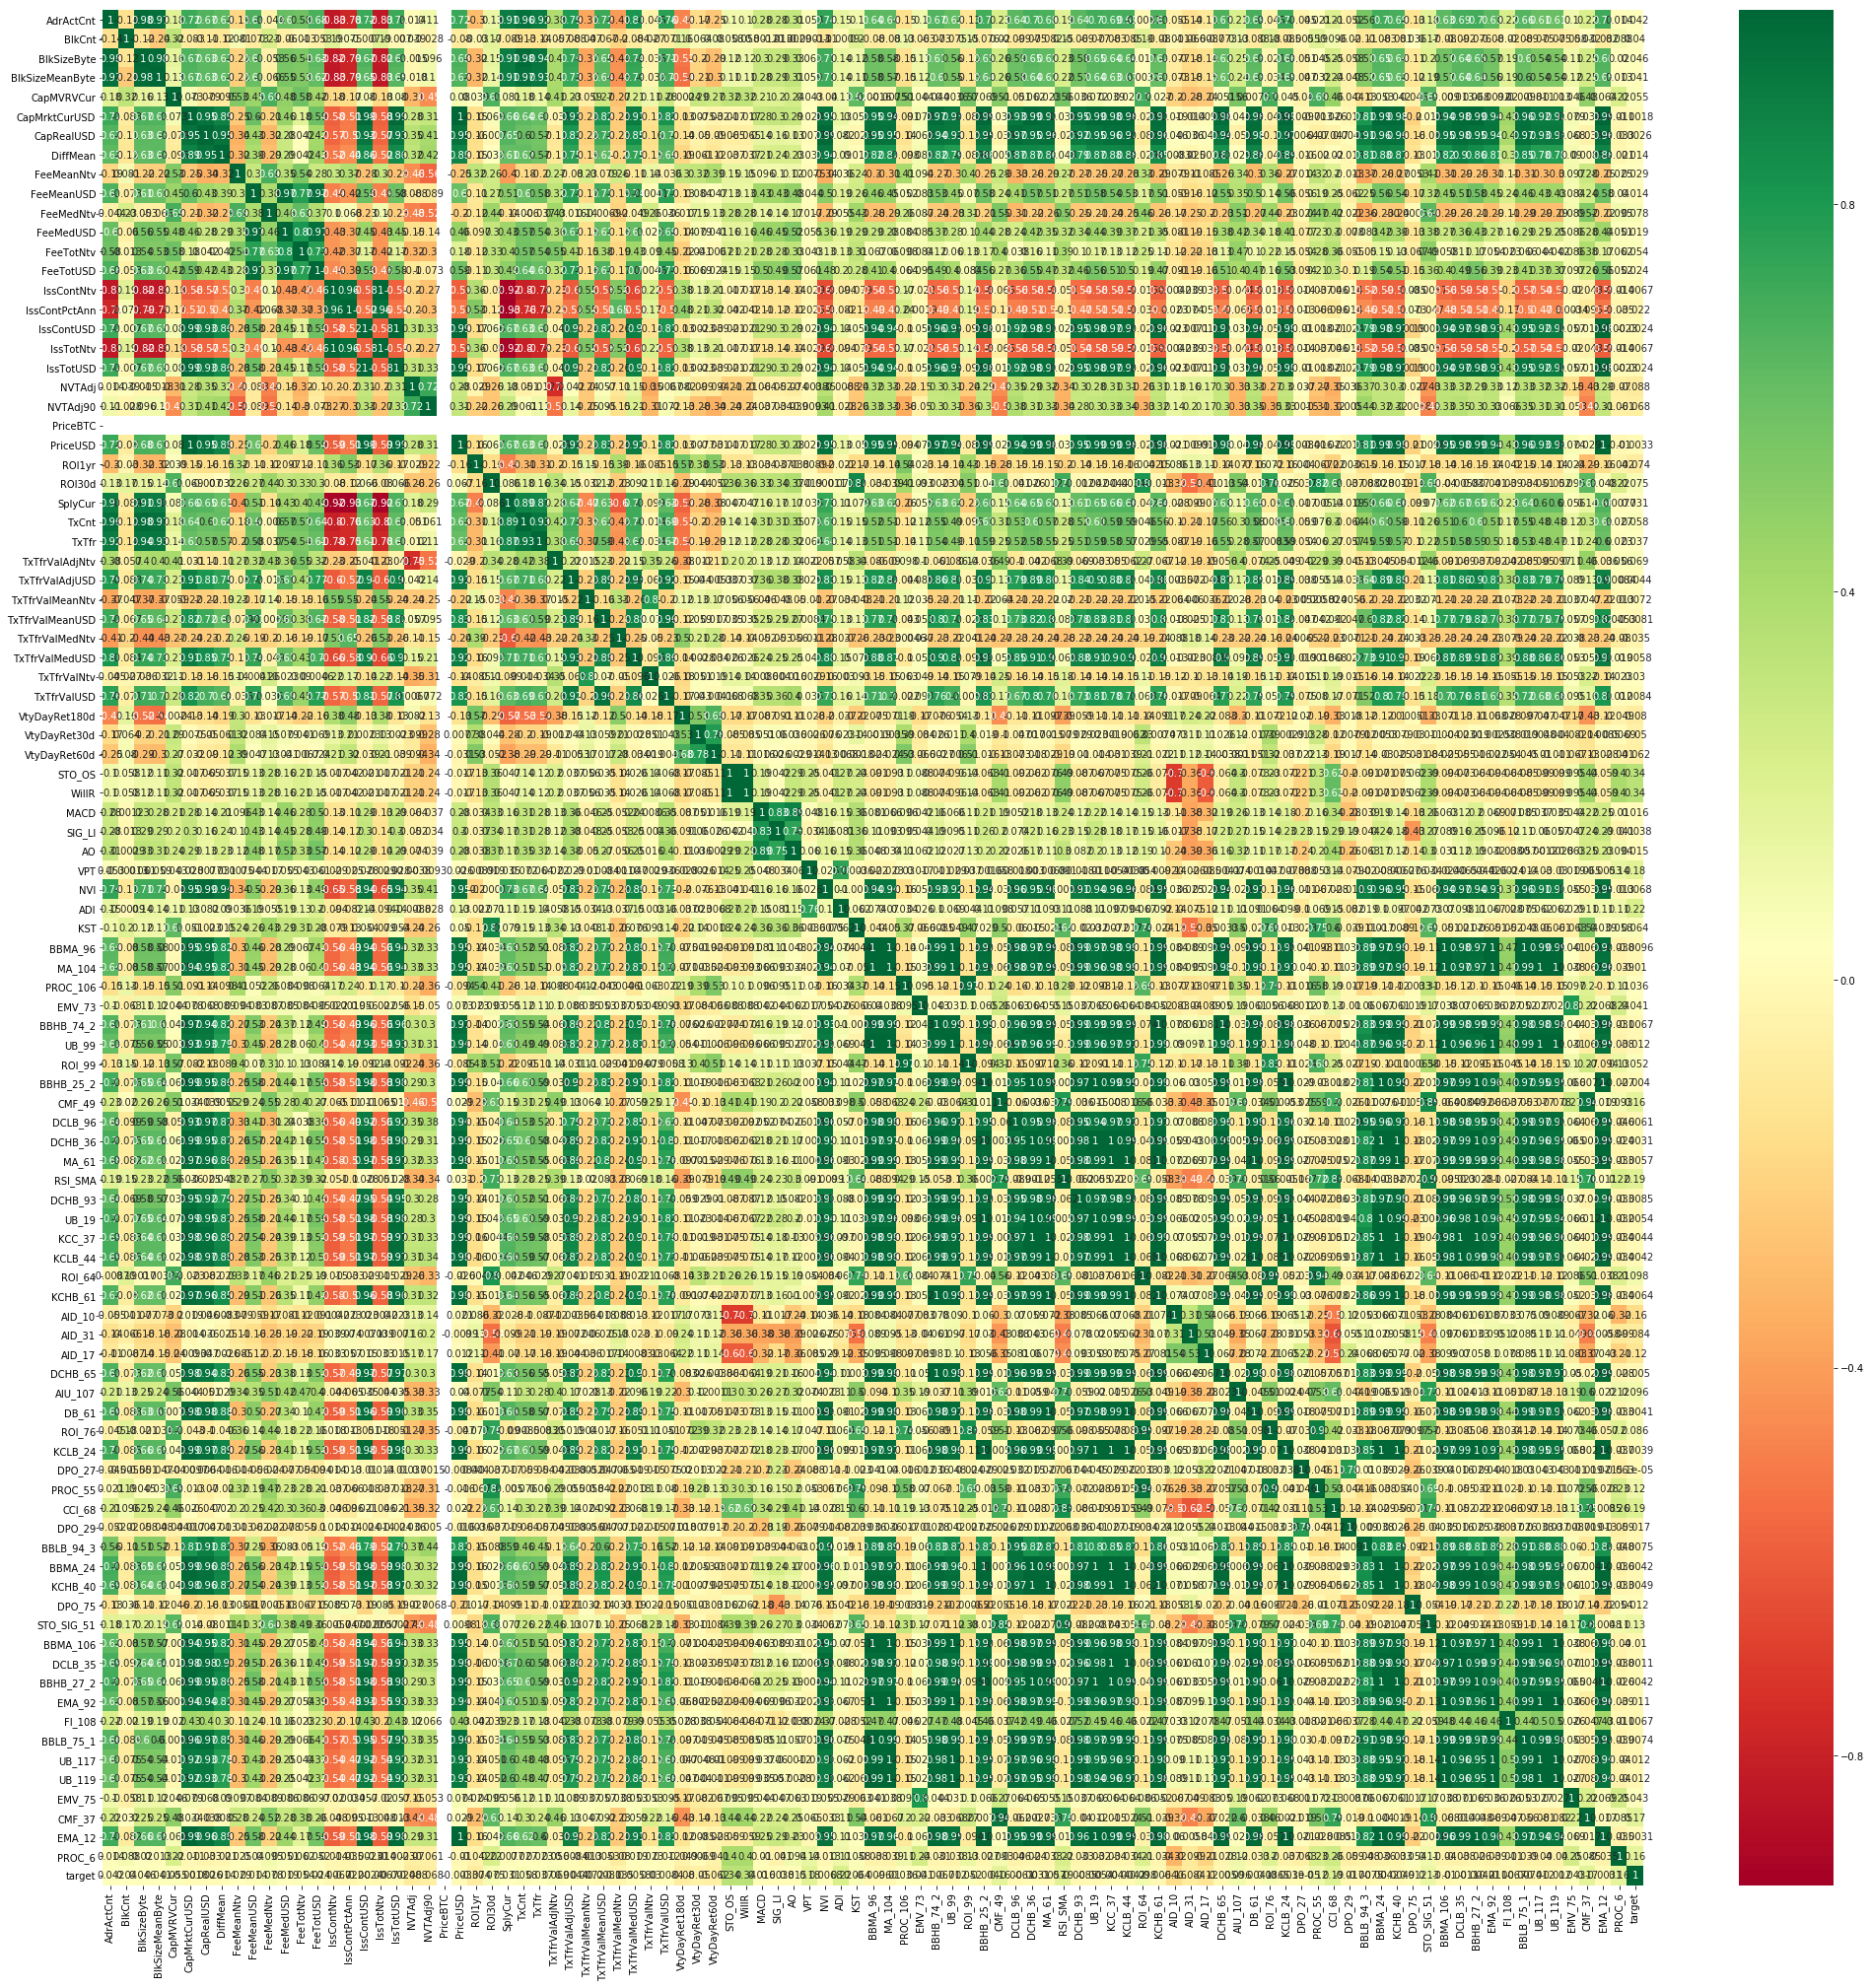

In [14]:
#Can be used after 
#get correlations of each features in dataset
corrmat = features_target.corr()
corr_features = corrmat.index
plt.figure(figsize=(35,35))
#plot heat map
g=sns.heatmap(features_target.corr(),annot=True,cmap="RdYlGn")

In [18]:
def modelfit(alg, X, Y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X, Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X, Y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(Y.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(Y, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(10,10))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

# XGB_PCA Model

In [ ]:
#PCA Analysis
#We keep 25 components to make sure the sum of explained variation of the principal components is close to 98%
#To improve accuracy and efficiency
pca = PCA(n_components=25)
X = pd.DataFrame(pca.fit_transform(X),index=X.index)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum of Explained variation of principal component: {}'.format(sum(pca.explained_variance_ratio_)))

#Data Set Preparation 
X_test = X.iloc[int(len(X.index)*0.6):]
X_train = X.iloc[:int(len(X.index)*0.6)]
y_test = Y.iloc[int(len(Y.index)*0.6):]
Y_train = Y.iloc[:int(len(Y.index)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

In [ ]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.6523952 | Std - 0.0177091 | Min - 0.6207751 | Max - 0.6722028


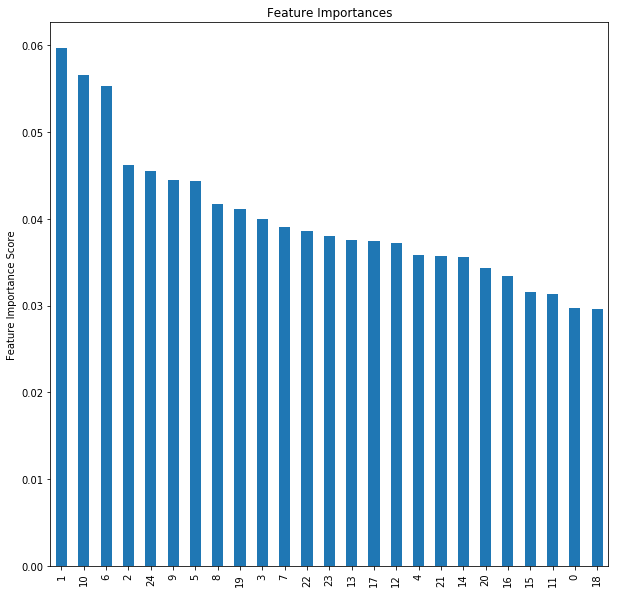

In [19]:
#XGBoost Hyperparameters tuning 
#creating a baseline model without tuning (assuming initial values)
XGB0 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB0, X_train, y_train['target'])

In [26]:
#XGBoost: learning_rate, n_estimators
param_test1 = {
    'learning_rate':[0.0001,0.001,0.005,0.01,0.05,0.1],
    'n_estimators':[100,200,300,400,500,800,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train['target'])
print('1:',gsearch1.best_params_, gsearch1.best_score_)

#XGBoost: max_depth, min_child_weight
param_test2 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train, y_train['target'])
print('2:',gsearch2.best_params_, gsearch2.best_score_)

#XGBoost: gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train, y_train['target'])
print('3:',gsearch3.best_params_, gsearch3.best_score_)

#XGBoost: subsample, colsample_bytree
param_test4 = {
 'subsample':[i/100.0 for i in range(60,100,5)],
 'colsample_bytree':[i/100.0 for i in range(60,100,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train, y_train['target'])
print('4:',gsearch4.best_params_, gsearch4.best_score_)

#XGBoost: reg_alpha
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], colsample_bytree=gsearch4.best_params_['colsample_bytree'],
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train, y_train['target'])
print('5:',gsearch5.best_params_, gsearch5.best_score_)

1: {'learning_rate': 0.01, 'n_estimators': 300} 0.6852393860820827
2: {'max_depth': 3, 'min_child_weight': 5} 0.699303318404442
3: {'gamma': 0.3} 0.6998556219061838
4: {'colsample_bytree': 0.75, 'subsample': 0.6} 0.7022164165422593
5: {'reg_alpha': 1e-05} 0.7022164165422593



Model Report
Accuracy : 0.775
AUC Score (Train): 0.862050
CV Score : Mean - 0.7022164 | Std - 0.03183409 | Min - 0.6593823 | Max - 0.755546


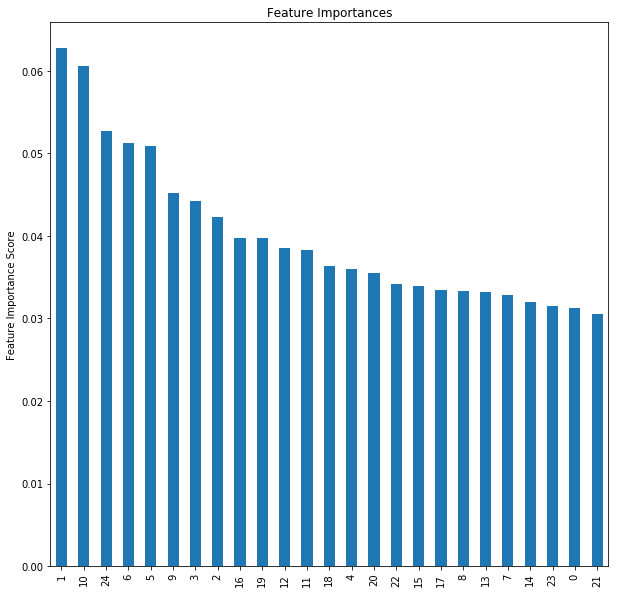

In [31]:
XGB_PCA = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], 
                     max_depth=gsearch2.best_params_['max_depth'],min_child_weight=gsearch2.best_params_['min_child_weight'], 
                     gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], 
                     colsample_bytree=gsearch4.best_params_['colsample_bytree'], reg_alpha=gsearch5.best_params_['reg_alpha'],objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(XGB_PCA, X_train, y_train['target'])

In [37]:
#Default XGBoost
x_prediction = X_val
model = XGBClassifier()        
print("# Training 'Default XGBoost'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#Initial XGB0
x_prediction = X_val
model = XGB0        
print("# Training 'XGB0'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#XBG_PCA
x_prediction = X_val
model = XGB_PCA   
print("# Training 'XGB_PCA'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))

# Training 'Default XGBoost'
# Predicting...
- probabilities: [0.7563609  0.4878829  0.43788204 0.542547   0.615404  ]
- accuracy:  0.6526610644257703
- validation logloss: 0.6355788603383286


# Training 'XGB0'
# Predicting...
- probabilities: [0.8507804  0.17937714 0.31062195 0.96789026 0.86881566]
- accuracy:  0.6610644257703081
- validation logloss: 1.0127267069243413


# Training 'XGB_PCA'
# Predicting...
- probabilities: [0.5513549  0.4682259  0.39459804 0.46372572 0.5966299 ]
- accuracy:  0.6554621848739496
- validation logloss: 0.6269930275548407


In [38]:
#XGB_PCA test_data prediction
model = XGB_PCA  
model.fit(X_train, y_train['target'])
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'PCA prediction': results},index=X_test.index)
Close = pd.DataFrame(data={'PCA Close': y_test['Close']})
prob = prob.join(Close)

In [40]:
#assuming zero risk free rate
#sharpe ratio 
#max drawdown
#absolute return
performance_df = pd.DataFrame(index=['Sharpe_Ratio (per transaction)','Sharpe_Ratio (Annualized)','Max_Drawdown','Absolute_return'])
def performance(prediction, close):
    Investment=[]
    Capital=[]
    Prices=[]
    for i in range(len(prediction)):
        if prediction.iloc[i]==1:
            Prices.append(close.iloc[i])
        if i==0 and prediction.iloc[i]==1:
            Capital.append(close.iloc[i])
        if i>0 and prediction.iloc[i-1]==0 and prediction.iloc[i]==1:
            Capital.append(close.iloc[i])
        if i>0 and prediction.iloc[i-1]==1 and prediction.iloc[i]==0:
            Investment.append(close.iloc[i])
            Prices.append(close.iloc[i])
        if i==len(prediction)-1 and prediction.iloc[i]==1:
            Investment.append(close.iloc[i])
    absolute_return=np.log(np.sum(Investment)/np.sum(Capital))
    returns = pd.DataFrame(np.log(np.array(Investment)/np.array(Capital))).replace([np.inf, -np.inf], np.nan).dropna()
    avg_return = float(np.mean(returns))
    std = float(np.std(returns))
    SR = avg_return/std
    SR_ann = SR*(len(Investment)**0.5)/(len(Prices)**0.5)*(252**0.5)
    max_drawdown = (min(Prices)-max(Prices))/max(Prices)
    return SR, SR_ann, max_drawdown, absolute_return
results = performance(prob['PCA prediction'],prob['PCA Close'])
performance_df['XGB_PCA'] = results
performance_df

XGB_PCA
Sharpe_Ratio (per transaction)  0.293584
Sharpe_Ratio (Annualized)       1.867982
Max_Drawdown                   -0.960240
Absolute_return                 0.033543

# Benchmark learning (all features included)

In [41]:
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [42]:
#Data Set Preparation 
X_test = X.iloc[int(len(X.index)*0.6):]
X_train = X.iloc[:int(len(X.index)*0.6)]
y_test = Y.iloc[int(len(Y.index)*0.6):]
Y_train = Y.iloc[:int(len(Y.index)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

In [43]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

(831, 96) (831, 2)
(357, 96) (357, 2)
(793, 96) (793, 2)



Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.7656354 | Std - 0.02081918 | Min - 0.735811 | Max - 0.7929779


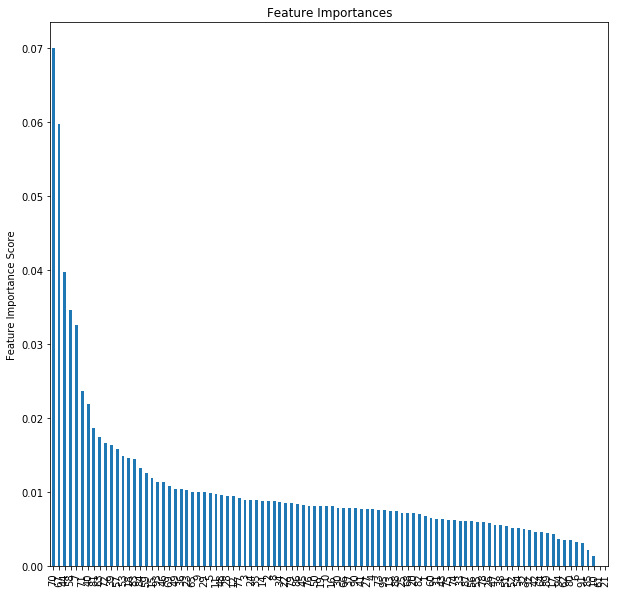

In [44]:
#XGBoost Hyperparameters tuning 
#creating a baseline model without tuning (assuming initial values)
XGB0 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB0, X_train, y_train['target'])

In [45]:
#XGBoost: learning_rate, n_estimators
param_test1 = {
    'learning_rate':[0.0001,0.001,0.005,0.01,0.05,0.1],
    'n_estimators':[100,200,300,400,500,800,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train['target'])
print('1:',gsearch1.best_params_, gsearch1.best_score_)

#XGBoost: max_depth, min_child_weight
param_test2 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train, y_train['target'])
print('2:',gsearch2.best_params_, gsearch2.best_score_)

#XGBoost: gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train, y_train['target'])
print('3:',gsearch3.best_params_, gsearch3.best_score_)

#XGBoost: subsample, colsample_bytree
param_test4 = {
 'subsample':[i/100.0 for i in range(60,100,5)],
 'colsample_bytree':[i/100.0 for i in range(60,100,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train, y_train['target'])
print('4:',gsearch4.best_params_, gsearch4.best_score_)

#XGBoost: reg_alpha
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], colsample_bytree=gsearch4.best_params_['colsample_bytree'],
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train, y_train['target'])
print('5:',gsearch5.best_params_, gsearch5.best_score_)

1: {'learning_rate': 0.005, 'n_estimators': 500} 0.8411752573269429
2: {'max_depth': 4, 'min_child_weight': 2} 0.8493141222073806
3: {'gamma': 0.9} 0.8500104764149707
4: {'colsample_bytree': 0.6, 'subsample': 0.95} 0.855043739032503
5: {'reg_alpha': 0.01} 0.8553063041827086



Model Report
Accuracy : 0.8327
AUC Score (Train): 0.940217
CV Score : Mean - 0.8553063 | Std - 0.01616417 | Min - 0.8388695 | Max - 0.8847611


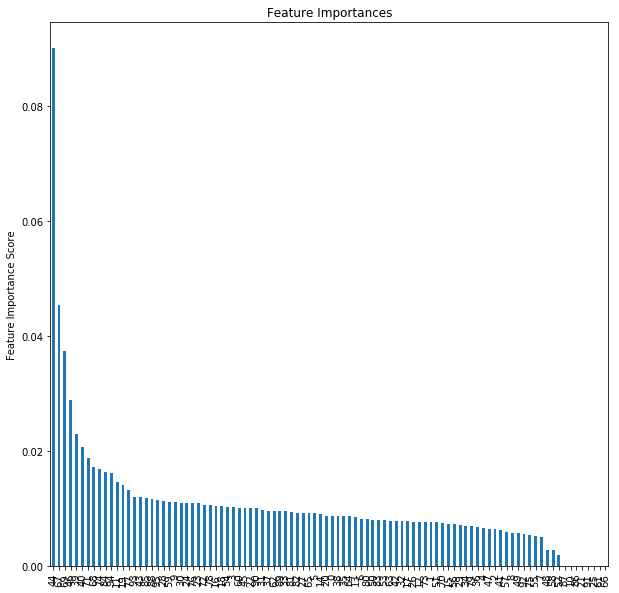

In [46]:
XGB_Bench = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], 
                     max_depth=gsearch2.best_params_['max_depth'],min_child_weight=gsearch2.best_params_['min_child_weight'], 
                     gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], 
                     colsample_bytree=gsearch4.best_params_['colsample_bytree'], reg_alpha=gsearch5.best_params_['reg_alpha'],objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(XGB_Bench, X_train, y_train['target'])

In [48]:
#Default XGBoost
x_prediction = X_val
model = XGBClassifier()        
print("# Training 'Default XGBoost'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#Initial XGB0
x_prediction = X_val
model = XGB0        
print("# Training 'XGB0'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#XBG_Bench
x_prediction = X_val
model = XGB_Bench  
print("# Training 'XGB_Bench'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))

# Training 'Default XGBoost'
# Predicting...
- probabilities: [0.8105717  0.7390651  0.22328456 0.44590768 0.68580085]
- accuracy:  0.7535014005602241
- validation logloss: 0.45283186886882204


# Training 'XGB0'
# Predicting...
- probabilities: [0.7732047  0.8890168  0.1597532  0.63135797 0.91992384]
- accuracy:  0.7086834733893558
- validation logloss: 0.7844223520564517


# Training 'XGB_Bench'
# Predicting...
- probabilities: [0.49653757 0.67324996 0.3399565  0.4358281  0.713268  ]
- accuracy:  0.7535014005602241
- validation logloss: 0.4822023067967731


In [51]:
#Default XGBoost
model = XGBClassifier() 
model.fit(X_train, y_train['target'])
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'Bench prediction': results},index=X_test.index)
Close = pd.DataFrame(data={'Bench Close': y_test['Close']})
prob = prob.join(Close)
prob

Bench prediction   Bench Close
2016-05-30                 0    528.919983
2016-05-31                 1    537.400024
2016-06-01                 0    537.099976
2016-06-02                 1    567.030029
2016-06-03                 1    571.950012
...                      ...           ...
2019-07-16                 1   9696.150391
2019-07-17                 1  10638.349609
2019-07-18                 1  10532.940430
2019-07-19                 1  10759.419922
2019-07-20                 0  10586.709961

[799 rows x 2 columns]

In [52]:
#assuming zero risk free rate
#sharpe ratio 
#max drawdown
#absolute return
results = performance(prob['Bench prediction'],prob['Bench Close'])
performance_df['XGB_Bench'] = results
performance_df

XGB_PCA  XGB_Bench
Sharpe_Ratio (per transaction)  0.293584   0.173277
Sharpe_Ratio (Annualized)       1.867982   1.500849
Max_Drawdown                   -0.960240  -0.958407
Absolute_return                 0.033543   0.010576

# PCA-DWT

In [53]:
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [54]:
#We keep 25 components to make sure the sum of explained variation of the principal components is close to 98%
#To improve accuracy and efficiency
pca = PCA(n_components=25)
X = pd.DataFrame(pca.fit_transform(X),index=X.index)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum of Explained variation of principal component: {}'.format(sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.58358227 0.13885329 0.06169631 0.04843174 0.02577632 0.02121715
 0.01523107 0.01439654 0.01165985 0.01106557 0.00969437 0.00712453
 0.00629828 0.00455577 0.00418857 0.00367514 0.0031793  0.00272852
 0.00257039 0.00218615 0.00203162 0.0019736  0.00158308 0.00147022
 0.00122192]
Sum of Explained variation of principal component: 0.9863915568956667


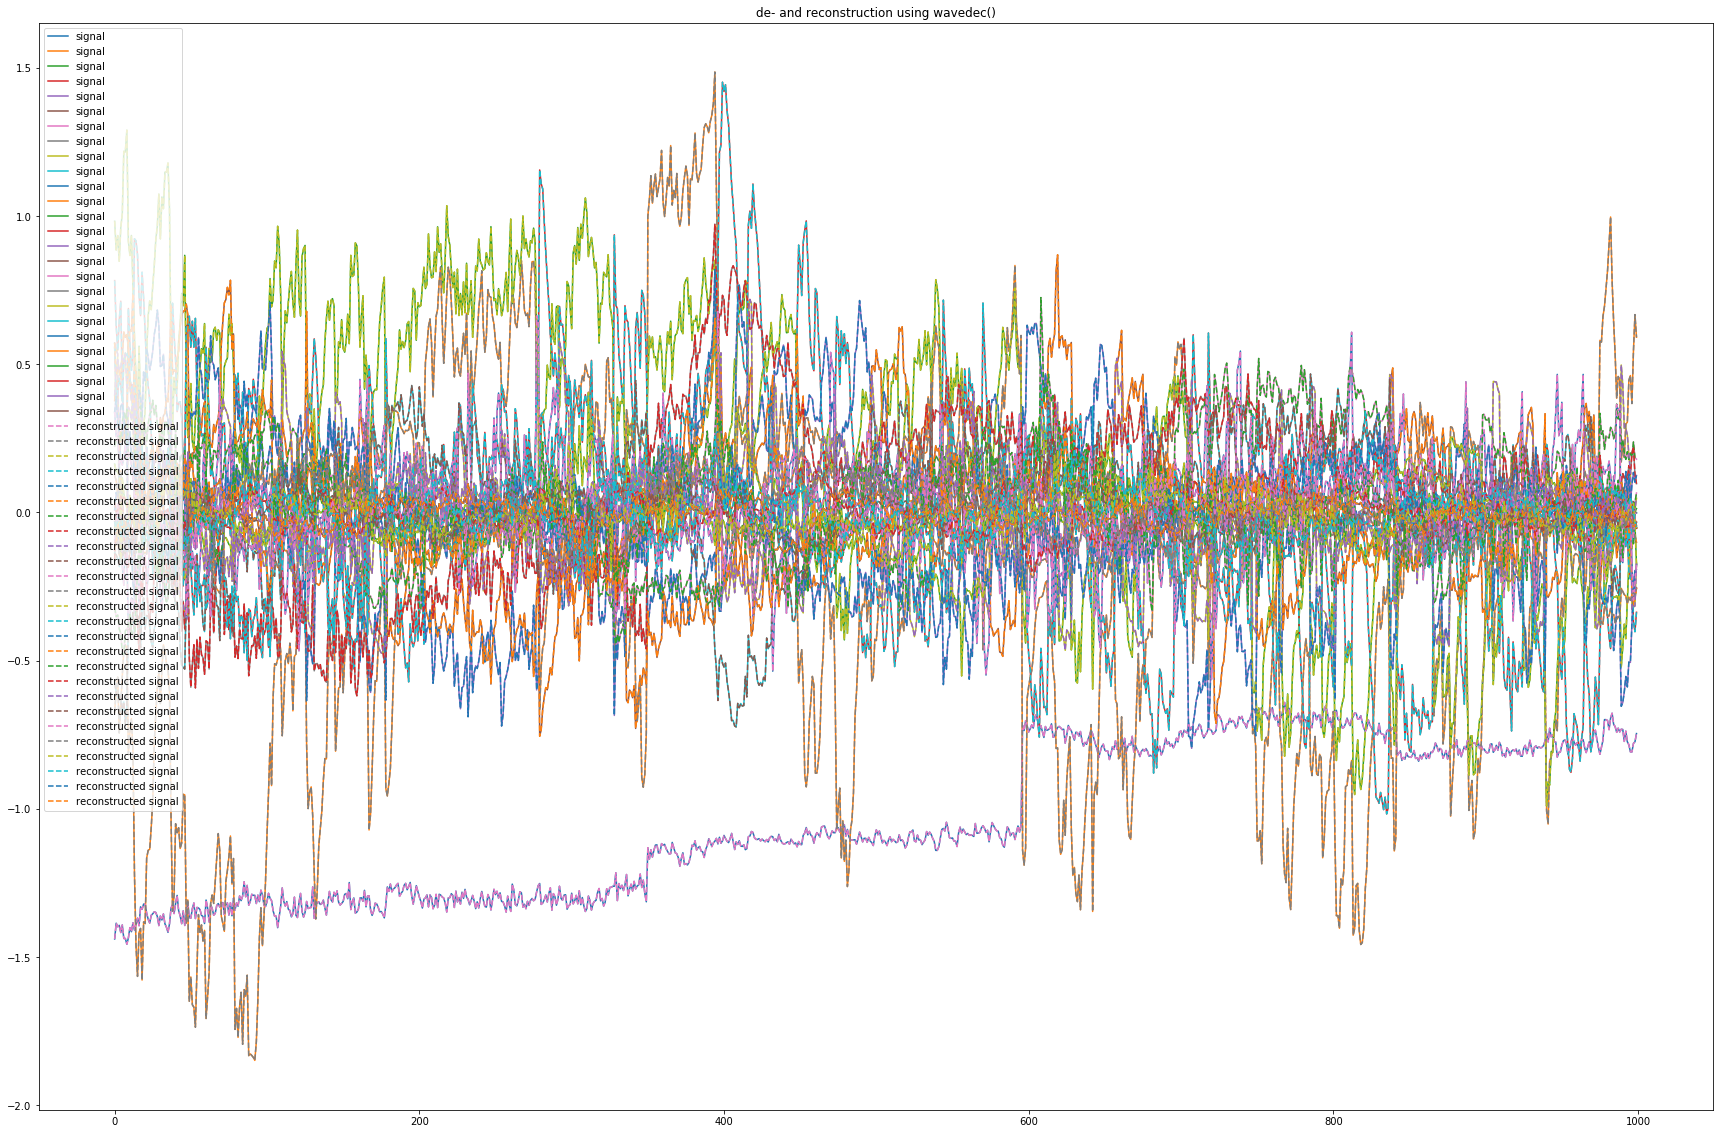

In [55]:
import pywt
coeffs = pywt.wavedec(X, 'db2', level=3)
X = pywt.waverec(coeffs, 'db2')
 
fig, ax = plt.subplots(figsize=(30,20))
ax.plot(X[:1000], label='signal')
ax.plot(X[:1000], label='reconstructed signal', linestyle='--')
ax.legend(loc='upper left')
ax.set_title('de- and reconstruction using wavedec()')
plt.show()

In [56]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

In [60]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

(831, 26) (831, 2)
(357, 26) (357, 2)
(793, 26) (793, 2)



Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.6599624 | Std - 0.0237558 | Min - 0.6148019 | Max - 0.6806396


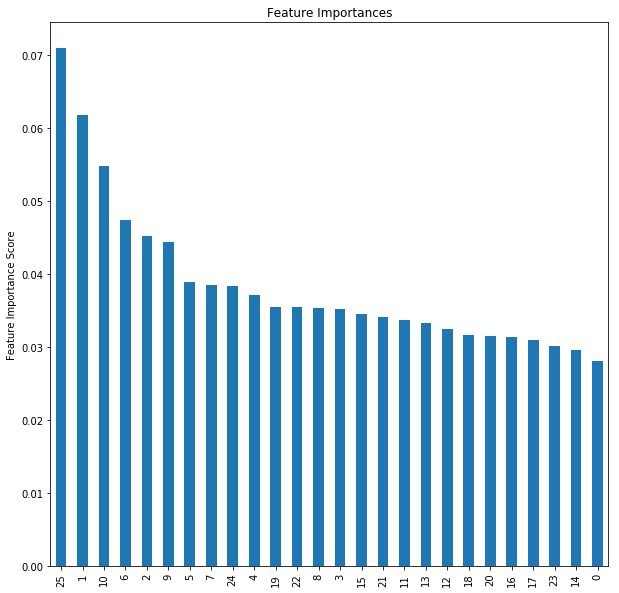

In [58]:
#XGBoost Hyperparameters tuning 
#creating a baseline model without tuning (assuming initial values)
XGB0 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB0, X_train, y_train['target'])

In [59]:
#XGBoost: learning_rate, n_estimators
param_test1 = {
    'learning_rate':[0.0001,0.001,0.005,0.01,0.05,0.1],
    'n_estimators':[100,200,300,400,500,800,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train['target'])
print('1:',gsearch1.best_params_, gsearch1.best_score_)

#XGBoost: max_depth, min_child_weight
param_test2 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train, y_train['target'])
print('2:',gsearch2.best_params_, gsearch2.best_score_)

#XGBoost: gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train, y_train['target'])
print('3:',gsearch3.best_params_, gsearch3.best_score_)

#XGBoost: subsample, colsample_bytree
param_test4 = {
 'subsample':[i/100.0 for i in range(60,100,5)],
 'colsample_bytree':[i/100.0 for i in range(60,100,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train, y_train['target'])
print('4:',gsearch4.best_params_, gsearch4.best_score_)

#XGBoost: reg_alpha
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], max_depth=gsearch2.best_params_['max_depth'],
 min_child_weight=gsearch2.best_params_['min_child_weight'], gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], colsample_bytree=gsearch4.best_params_['colsample_bytree'],
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train, y_train['target'])
print('5:',gsearch5.best_params_, gsearch5.best_score_)

1: {'learning_rate': 0.01, 'n_estimators': 300} 0.6863931012807417
2: {'max_depth': 3, 'min_child_weight': 1} 0.6999950891804824
3: {'gamma': 0.1} 0.7001119666850004
4: {'colsample_bytree': 0.95, 'subsample': 0.7} 0.7042982766297372
5: {'reg_alpha': 1e-05} 0.7042982766297372



Model Report
Accuracy : 0.7906
AUC Score (Train): 0.882069
CV Score : Mean - 0.7042983 | Std - 0.03413548 | Min - 0.6606935 | Max - 0.7626044


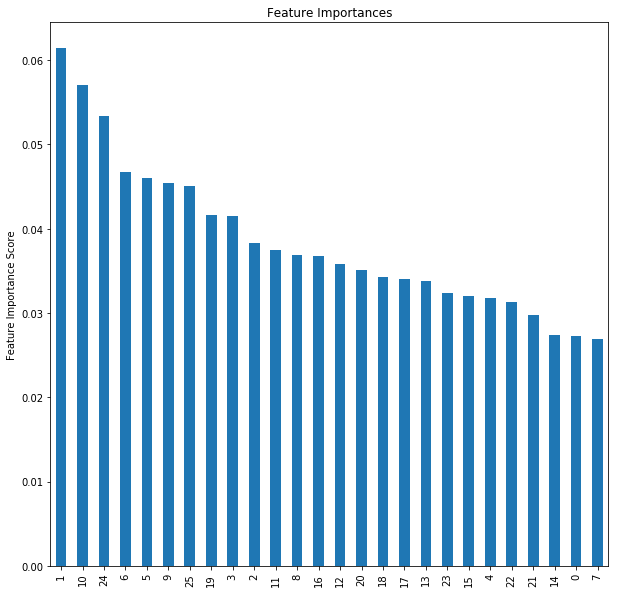

In [61]:
XGB_PCA_DWT = XGBClassifier(learning_rate =gsearch1.best_params_['learning_rate'], n_estimators=gsearch1.best_params_['n_estimators'], 
                     max_depth=gsearch2.best_params_['max_depth'],min_child_weight=gsearch2.best_params_['min_child_weight'], 
                     gamma=gsearch3.best_params_['gamma'], subsample=gsearch4.best_params_['subsample'], 
                     colsample_bytree=gsearch4.best_params_['colsample_bytree'], reg_alpha=gsearch5.best_params_['reg_alpha'],objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(XGB_PCA_DWT, X_train, y_train['target'])

In [64]:
#Default XGBoost
x_prediction = X_val
model = XGBClassifier()        
print("# Training 'Default XGBoost'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#Initial XGB0
x_prediction = X_val
model = XGB0        
print("# Training 'XGB0'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

#XBG_PCA_DWT
x_prediction = X_val
model = XGB_PCA_DWT  
print("# Training 'XGB_PCA_DWT'")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))

# Training 'Default XGBoost'
# Predicting...
- probabilities: [0.70987356 0.51613915 0.37045583 0.5777463  0.6612464 ]
- accuracy:  0.6414565826330533
- validation logloss: 0.636200197604524


# Training 'XGB0'
# Predicting...
- probabilities: [0.9383889  0.25934547 0.23394915 0.9506411  0.9485972 ]
- accuracy:  0.6638655462184874
- validation logloss: 1.0314737775175564


# Training 'XGB_PCA_DWT'
# Predicting...
- probabilities: [0.5739385  0.48700893 0.38791516 0.4709758  0.6258151 ]
- accuracy:  0.6750700280112045
- validation logloss: 0.627686353457742


In [67]:
#XGB_PCA_DWT
model = XGB_PCA_DWT 
model.fit(X_train, y_train['target'])
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'XGB_PCA_DWT prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'XGB_PCA_DWT Close': y_test['Close']})
prob = prob.join(Close)
prob

XGB_PCA_DWT prediction  XGB_PCA_DWT Close
2016-05-30                       1         528.919983
2016-05-31                       1         537.400024
2016-06-01                       1         537.099976
2016-06-02                       1         567.030029
2016-06-03                       1         571.950012
...                            ...                ...
2019-07-16                       1        9696.150391
2019-07-17                       0       10638.349609
2019-07-18                       0       10532.940430
2019-07-19                       0       10759.419922
2019-07-20                       0       10586.709961

[799 rows x 2 columns]

In [73]:
results = performance(prob['XGB_PCA_DWT prediction'],prob['XGB_PCA_DWT Close'])
performance_df['XGB_PCA_DWT'] = results
performance_df

XGB_PCA  XGB_Bench  XGB_PCA_DWT
Sharpe_Ratio (per transaction)  0.293584   0.173277     0.311839
Sharpe_Ratio (Annualized)       1.867982   1.500849     2.086735
Max_Drawdown                   -0.960240  -0.958407    -0.960240
Absolute_return                 0.033543   0.010576     0.029410

# SGD

In [74]:
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [75]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)

(831, 96) (831, 2)
(357, 96) (357, 2)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    3.1s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    3.2s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    3.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    3.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.2s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.6s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.7s finished


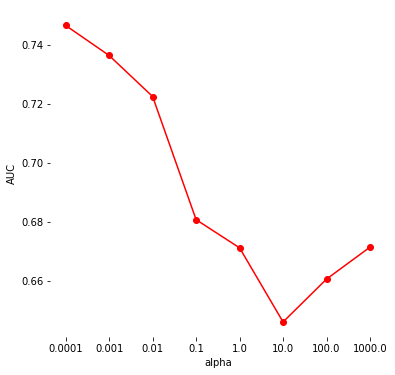

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.7465116279069767


In [76]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf

grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'n_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

In [77]:
#Best SGD
x_prediction = X_val
model = bestModel
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'SGD prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'SGD Close': y_test['Close']})
prob = prob.join(Close)
prob

# Training...
# Predicting...
- probabilities: [0.55832369 0.51662705 0.33599601 0.50198011 0.65398666]
- accuracy:  0.6778711484593838
- validation logloss: 0.5986364775733972




SGD prediction     SGD Close
2016-05-30               1    528.919983
2016-05-31               1    537.400024
2016-06-01               1    537.099976
2016-06-02               1    567.030029
2016-06-03               1    571.950012
...                    ...           ...
2019-07-16               0   9696.150391
2019-07-17               1  10638.349609
2019-07-18               1  10532.940430
2019-07-19               1  10759.419922
2019-07-20               1  10586.709961

[799 rows x 2 columns]

In [79]:
results = performance(prob['SGD prediction'],prob['SGD Close'])
performance_df['SGD'] = results
performance_df = performance_df.drop(columns=['XGB)_PCA_DWT','PCA_DWT'])
performance_df

XGB_PCA  XGB_Bench  XGB_PCA_DWT       SGD
Sharpe_Ratio (per transaction)  0.293584   0.173277     0.311839  0.209387
Sharpe_Ratio (Annualized)       1.867982   1.500849     2.086735  1.037501
Max_Drawdown                   -0.960240  -0.958407    -0.960240 -0.957912
Absolute_return                 0.033543   0.010576     0.029410  0.015202

# SGD-PCA

In [80]:
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

In [81]:
#We keep 25 components to make sure the sum of explained variation of the principal components is close to 98%
#To improve accuracy and efficiency
pca = PCA(n_components=25)
X = pd.DataFrame(pca.fit_transform(X),index=X.index)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum of Explained variation of principal component: {}'.format(sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.58358227 0.13885329 0.06169631 0.04843174 0.02577632 0.02121715
 0.01523107 0.01439654 0.01165985 0.01106557 0.00969437 0.00712453
 0.00629828 0.00455577 0.00418857 0.00367514 0.0031793  0.00272852
 0.00257039 0.00218615 0.0020316  0.0019736  0.00158306 0.00147004
 0.00122149]
Sum of Explained variation of principal component: 0.9863909107675435


In [82]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)

(831, 25) (831, 2)
(357, 25) (357, 2)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.8s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.8s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    2.8s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.9s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.0s finished


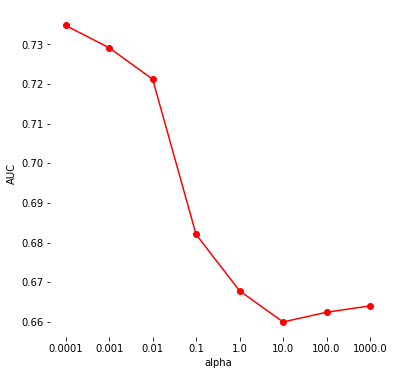

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.7347894406033941


In [83]:
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'n_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

In [84]:
#Best SGD
x_prediction = X_val
model = bestModel
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'SGD_PCA prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'SGD_PCA Close': y_test['Close']})
prob = prob.join(Close)
prob

# Training...
# Predicting...
- probabilities: [0.5825122  0.45520068 0.32476174 0.49138321 0.60629268]
- accuracy:  0.6694677871148459
- validation logloss: 0.6063633567143207




SGD_PCA prediction  SGD_PCA Close
2016-05-30                   1     528.919983
2016-05-31                   1     537.400024
2016-06-01                   1     537.099976
2016-06-02                   1     567.030029
2016-06-03                   1     571.950012
...                        ...            ...
2019-07-16                   1    9696.150391
2019-07-17                   1   10638.349609
2019-07-18                   1   10532.940430
2019-07-19                   1   10759.419922
2019-07-20                   1   10586.709961

[799 rows x 2 columns]

In [85]:
results = performance(prob['SGD_PCA prediction'],prob['SGD_PCA Close'])
performance_df['SGD_PCA'] = results
performance_df

XGB_PCA  XGB_Bench  XGB_PCA_DWT       SGD  \
Sharpe_Ratio (per transaction)  0.293584   0.173277     0.311839  0.209387   
Sharpe_Ratio (Annualized)       1.867982   1.500849     2.086735  1.037501   
Max_Drawdown                   -0.960240  -0.958407    -0.960240 -0.957912   
Absolute_return                 0.033543   0.010576     0.029410  0.015202   

                                 SGD_PCA  
Sharpe_Ratio (per transaction)  0.312776  
Sharpe_Ratio (Annualized)       1.352740  
Max_Drawdown                   -0.956284  
Absolute_return                 0.016014

In [102]:
performance_df = performance_df[['Benchmark','PCA','PCA_DWT','SGD','SGD_PCA']]
performance_df

Benchmark       PCA   PCA_DWT       SGD   SGD_PCA
Sharpe Ratio      0.150987  0.273371  0.246176  0.349147  0.302264
Max Drawdown     -0.960240 -0.960240 -0.960240 -0.960240 -0.960240
Absolute return   0.013880  0.039091  0.019120  0.070427  0.050792

# SVC

In [86]:
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

In [87]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)

(831, 96) (831, 2)
(357, 96) (357, 2)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:    6.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  51 out of  60 | elapsed:    6.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:    7.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.9s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.1s finished


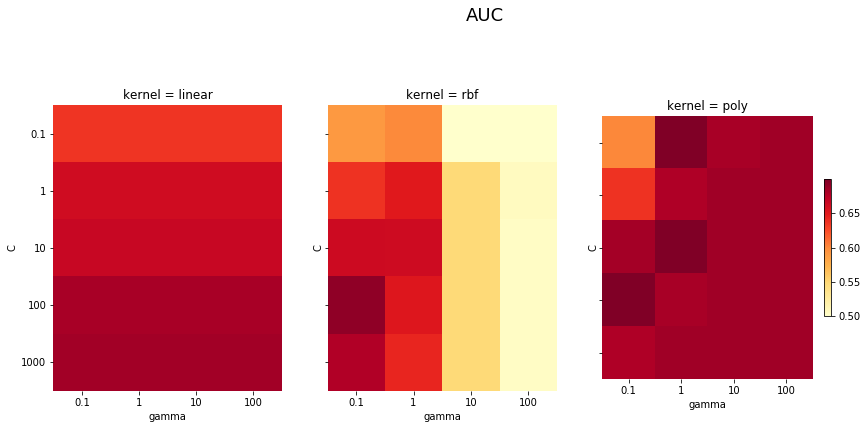

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.6989629164047769


In [88]:
from sklearn.svm import SVC
grid = {
    'kernel': ['linear','rbf','poly'],
    'gamma' : [0.1,1,10,100],
    'C': [0.1,1,10,100,1000],
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SVC, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

In [90]:
#Best SVC
model = bestModel
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'SVC prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'SVC Close': y_test['Close']})
prob = prob.join(Close)
prob

# Training...
# Predicting...


SVC prediction     SVC Close
2016-05-30               0    528.919983
2016-05-31               1    537.400024
2016-06-01               1    537.099976
2016-06-02               1    567.030029
2016-06-03               0    571.950012
...                    ...           ...
2019-07-16               1   9696.150391
2019-07-17               1  10638.349609
2019-07-18               1  10532.940430
2019-07-19               1  10759.419922
2019-07-20               1  10586.709961

[799 rows x 2 columns]

In [91]:
results = performance(prob['SVC prediction'],prob['SVC Close'])
performance_df['SVC'] = results
performance_df

XGB_PCA  XGB_Bench  XGB_PCA_DWT       SGD  \
Sharpe_Ratio (per transaction)  0.293584   0.173277     0.311839  0.209387   
Sharpe_Ratio (Annualized)       1.867982   1.500849     2.086735  1.037501   
Max_Drawdown                   -0.960240  -0.958407    -0.960240 -0.957912   
Absolute_return                 0.033543   0.010576     0.029410  0.015202   

                                 SGD_PCA       SVC  
Sharpe_Ratio (per transaction)  0.312776  0.294168  
Sharpe_Ratio (Annualized)       1.352740  1.022511  
Max_Drawdown                   -0.956284 -0.960240  
Absolute_return                 0.016014  0.208519